In [1]:
from data_cleaning.helper_functions import Sample
from tslearn.datasets import CachedDatasets
import os
import numpy as np
from tqdm.notebook import tqdm
from dtaidistance import dtw, clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from sklearn.manifold import spectral_embedding
from sklearn.metrics import normalized_mutual_info_score,adjusted_mutual_info_score,mutual_info_score
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.stats import entropy
import pandas as pd

In [2]:
le = LabelEncoder()
le.fit(["M","X","B","C","F"])

LabelEncoder()

In [3]:
le.transform(["M","X","B","C","F"])

array([3, 4, 0, 1, 2])

In [4]:
mapping = {
    "B": 0,
    "C": 1,
    "F": 2,
    "M": 3,
    "X": 4
}
y_m = np.ones((100,1))*3
y_x = np.ones((100,1))*4
y_b = np.zeros((100,1))
y_c = np.ones((100,1))
y_f = np.ones((100,1))*2

y_flare =  np.vstack((y_m,y_x))
y_non_flare = np.vstack((y_b,y_c,y_f))
y = np.vstack((y_flare,y_non_flare))

In [150]:
def generate_flare_set(path):
    x_count = 10
    m_count = 10
    files = []
    for file in os.listdir(path):
#         files.append(file)
        if file[0] == 'M' and m_count >0:
            files.append(file)
            m_count-=1
        elif file[0] == "X" and x_count >0:
            files.append(file)
            x_count-=1
        
    return files

def generate_non_flare_set(path):
    b_count = 10
    c_count = 10
    f_count = 10
    files = []
    for file in os.listdir(path):
        
       
        if file[0] == 'B' and b_count > 0:
            files.append(file)
            b_count-=1
        elif file[0] == "C" and c_count > 0:
            files.append(file)
            c_count-=1
        
        elif file[0] == "F" and f_count > 0:
            files.append(file)
            f_count-=1
        
   
    return files

In [151]:
def get_embed_matrix(timeseries):
    ds = dtw.distance_matrix_fast(timeseries)
    ds = np.nan_to_num(ds)
    A = kneighbors_graph(ds, 3, mode='connectivity', include_self=True)
    A = 0.5* (A + A.T)
    adj = A.todense()
    np.fill_diagonal(adj,0)
    A = scipy.sparse.csr_matrix(adj)
    G = nx.Graph(A)
    adj = nx.adjacency_matrix(G)
    embed = spectral_embedding(adj,1)
    return embed.flatten()

In [152]:
os.chdir("D:\PyCharm\mvts_fss_ay")
os.getcwd()

'D:\\PyCharm\\mvts_fss_ay'

In [153]:
path_FL = os.path.join(os.getcwd(),"data\\partition1\\FL")
path_NF = os.path.join(os.getcwd(),"data\\partition1\\NF")

files_flare = generate_flare_set(path_FL)
files_non_flare = generate_non_flare_set(path_NF)

In [154]:
len(files_flare), len(files_non_flare)

(20, 30)

In [790]:
s1 = list(Sample("FL",files_flare[0]).get_data().columns)[:25]
column_mapping = {}
for i in range(len(s1)):
    column_mapping[i] = s1[i]
column_mapping

{0: 'Timestamp',
 1: 'TOTUSJH',
 2: 'TOTBSQ',
 3: 'TOTPOT',
 4: 'TOTUSJZ',
 5: 'ABSNJZH',
 6: 'SAVNCPP',
 7: 'USFLUX',
 8: 'TOTFZ',
 9: 'MEANPOT',
 10: 'EPSZ',
 11: 'MEANSHR',
 12: 'SHRGT45',
 13: 'MEANGAM',
 14: 'MEANGBT',
 15: 'MEANGBZ',
 16: 'MEANGBH',
 17: 'MEANJZH',
 18: 'TOTFY',
 19: 'MEANJZD',
 20: 'MEANALP',
 21: 'TOTFX',
 22: 'EPSY',
 23: 'EPSX',
 24: 'R_VALUE'}

In [134]:
def relevance_score(embed,y):
    mututal_information = mutual_info_score(y,embed)
    entropy_embed = entropy(embed)
    entropy_y = entropy(y)
    relevance_score = mututal_information / (np.sqrt(entropy_embed*entropy_y))
    return relevance_score

In [91]:
timeseries = []
y = []
scores = {}
for col in tqdm(range(1,3)):
    for file in tqdm(files_flare):
        s = Sample("FL",file).get_data().iloc[:,col].values
        y.append(mapping[file[0]])
        timeseries.append(s)
    
    for file in tqdm(files_non_flare):
        s = Sample("NF",file).get_data().iloc[:,col].values
        y.append(mapping[file[0]])
        timeseries.append(s)
    embed = get_embed_matrix(timeseries)

    kmeans = KMeans(n_clusters=5, random_state=0).fit(embed.reshape(-1,1))
    embed_y = kmeans.labels_.flatten()
    y = np.array(y).flatten()
    scores[column_mapping[col]]= relevance_score(embed_y,y)
    timeseries = []
    y = []
    


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

(50,)
(50,)
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
(50,)
(50,)
[3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

(50,)
(50,)
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
(50,)
(50,)
[3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2]


In [82]:
{k: v for k, v in sorted(scores.items(), key=lambda item: item[1],reverse=True)}

{'TOTUSJH': 0.0021166152144100475}

In [13]:
scores

{'TOTUSJH': 0.014374077709574072,
 'TOTBSQ': 0.0037444916281059435,
 'TOTPOT': 0.005467376632119672,
 'TOTUSJZ': 0.012173725685899667,
 'ABSNJZH': 0.007761854086786744,
 'SAVNCPP': 0.019691605912405374,
 'USFLUX': 0.006379430545517045,
 'TOTFZ': 0.0024555014725031374,
 'MEANPOT': 0.011181638804389122,
 'EPSZ': 0.005982959486485345,
 'MEANSHR': 0.002660445564441396,
 'SHRGT45': 0.0016631978741523167,
 'MEANGAM': 0.008792074391792377,
 'MEANGBT': 0.0027204847714847034,
 'MEANGBZ': 0.0017885692527516465,
 'MEANGBH': 0.00028644728293026494,
 'MEANJZH': 0.0021037109444940233,
 'TOTFY': 0.01157797150356248,
 'MEANJZD': 0.004052290932109721,
 'MEANALP': 0.0013849149388306023,
 'TOTFX': 0.00569695945479917,
 'EPSY': 0.0012792205994325687,
 'EPSX': 0.006998805588639979,
 'R_VALUE': 0.0017301167605317084}

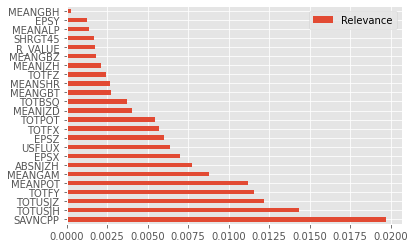

In [14]:
scores_data = pd.DataFrame.from_dict(scores,orient='index',columns=['Relevance']).sort_values(by='Relevance', ascending=False)
scores_data.plot(kind='barh');

In [ ]:
timeseries = []
timeseries = [s1,s2,s3,s4,s5,s6]
ds = dtw.distance_matrix_fast(timeseries)
ds = np.nan_to_num(ds)
A = kneighbors_graph(ds, 3, mode='connectivity', include_self=True)
# G = nx.Graph(A)
# nx.draw_spectral(G)
A = 0.5* (A + A.T)
adj = A.todense()
np.fill_diagonal(adj,0)
A = scipy.sparse.csr_matrix(adj)
G = nx.Graph(A)
# nx.draw_spectral(G)
adj = nx.adjacency_matrix(G)
embed = spectral_embedding(adj,1)
# y_1 = np.ones((6,1)) # M
# y_2 = np.zeros((6,1))
# y = np.vstack((y_1,y_2))

# normalized_mutual_info_score(embed.flatten(), y.flatten())

In [ ]:
embed

In [ ]:
# timeseries = []
# for file in tqdm(files):
#     data = Sample("FL",file).get_data().iloc[:,1].to_numpy()
#     timeseries.append(data)

In [ ]:
# ds = dtw.distance_matrix_fast(timeseries)
# ds

In [ ]:
ds.shape

In [ ]:
ds = np.nan_to_num(ds)

In [ ]:
Z = linkage(ds,method='single')
fig = plt.figure(figsize=(25, 25))
dn = dendrogram(Z)

In [ ]:
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(ds, 3, mode='connectivity', include_self=True)
plt.spy(A);

In [ ]:
G = nx.Graph(A)

In [ ]:
nx.draw_spectral(G)

In [ ]:
A = 0.5* (A + A.T)
adj = A.todense()
np.fill_diagonal(adj,0)
A = scipy.sparse.csr_matrix(adj)
# A = A.setdiag(0)

In [ ]:
adj

In [ ]:
print(A)

In [ ]:
G = nx.Graph(A)
nx.draw_spectral(G)

In [ ]:
adj = nx.adjacency_matrix(G)

In [ ]:
adj.shape

In [ ]:
degree_matrix.shape

In [ ]:
embed = spectral_embedding(adj,1)

In [ ]:
y_1 = np.ones((100,1)) # M
y_2 = np.zeros((100,1))
y = np.vstack((y_1,y_2))
y.shape

In [ ]:
normalized_mutual_info_score(embed.flatten(), y.flatten())

In [ ]:
embed

## Coordinate descent

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets
from sklearn.linear_model import lasso_path
%matplotlib inline
plt.style.use('seaborn-white')

In [16]:
#Load the diabetes dataset. In this case we will not be using a constant intercept feature
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target.reshape(-1,1)

In [18]:
X.shape, y.shape

((442, 10), (442, 1))

In [20]:
def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

In [193]:
#Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

X / np.linalg.norm(X,axis=0)  # Standardize data (easier to set the l1_ratio parameter)
m,n = X.shape

In [194]:
m,n

(442, 10)

In [195]:
eps = 5e-5  # the smaller it is the longer is the path

In [196]:
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps, fit_intercept=False)

In [197]:
coefs_lasso.shape

(10, 100)

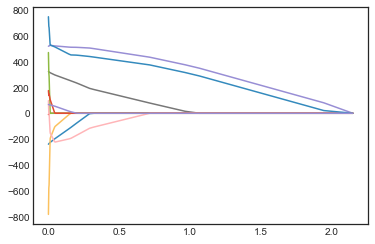

In [198]:
for i in range(n):
    plt.plot(alphas_lasso, coefs_lasso[i], label = diabetes.feature_names[i])

In [30]:
alphas_lasso.shape

(100,)

In [45]:
for i in range(len(coefs_lasso)):
    print(min(coefs_lasso[i]))

-9.903359993355807
-239.72041492458837
0.0
0.0
-784.4720033110269
0.0
-223.22862590100624
0.0
0.0
0.0


In [37]:

def lasso(X, y, l1, tol=1e-6, path_length=100, return_path=False):
    """The Lasso Regression model with intercept term.
    Intercept term included via design matrix augmentation.
    Pathwise coordinate descent with co-variance updates is applied.
    Path from max value of the L1 tuning parameter to input tuning parameter value.
    Features must be standardized (centered and scaled to unit variance)
    Params:
        X - NumPy matrix, size (N, p), of standardized numerical predictors
        y - NumPy array, length N, of numerical response
        l1 - L1 penalty tuning parameter (positive scalar)
        tol - Coordinate Descent convergence tolerance (exited if change < tol)
        path_length - Number of tuning parameter values to include in path (positive integer)
        return_path - Boolean indicating whether model coefficients along path should be returned
    Returns:
        if return_path == False:
            NumPy array, length p + 1, of fitted model coefficients
        if return_path == True:
            List, length 3, of last fitted model coefficients, tuning parameter path and coefficient values
    """
    X = np.hstack((np.ones((len(X), 1)), X))
    m, n = np.shape(X)
    B_star = np.zeros((n))
    l_max = max(list(abs(np.dot(np.transpose(X[:, 1:]), y)))) / m
    # At or above l_max, all coefficients (except intercept) will be brought to 0
    if l1 >= l_max:
        return np.append(np.mean(y), np.zeros((n - 1)))
    l_path = np.geomspace(l_max, l1, path_length)
    coeffiecients = np.zeros((len(l_path), n))
    for i in range(len(l_path)):
        while True:
            B_s = B_star
            for j in range(n):
                k = np.where(B_s != 0)[0]
                update = (1/m)*((np.dot(X[:,j], y)- \
                                np.dot(np.dot(X[:,j], X[:,k]), B_s[k]))) + \
                                B_s[j]
                B_star[j] = (np.sign(update) * max(abs(update) - l_path[i], 0))
            if np.all(abs(B_s - B_star) < tol):
                coeffiecients[i, :] = B_star
                break
    if return_path:
        return [B_star, l_path, coeffiecients]
    else:
        return B_star

In [42]:
b,l,coef = lasso(X,y,1,return_path=True)

In [44]:
coef.shape

(100, 11)

In [160]:

subset_data

,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,TOTFZ,MEANPOT,EPSZ,...,MEANGBH,MEANJZH,TOTFY,MEANJZD,MEANALP,TOTFX,EPSY,EPSX,R_VALUE,FLARE_CLASS


In [238]:
timeseries = []
y = []
scores = {}
labels = []
subset_data = pd.DataFrame(columns = Sample("FL",files_flare[0]).get_data().columns[1:25])
subset_data['FLARE_CLASS'] = np.nan
for col in tqdm(range(1,25)):
    for file in files_flare:
        s = Sample("FL",file).get_data().iloc[:,col].values
        
        
        timeseries.append(s)
        y.append(mapping[file[0]])
    
    for file in files_non_flare:
        s = Sample("NF",file).get_data().iloc[:,col].values
        y.append(mapping[file[0]])
        
        timeseries.append(s)
    labels.append(y)
    embed = get_embed_matrix(timeseries)
    subset_data.iloc[:,col-1] = embed
    timeseries = []
    y = []
subset_data.iloc[:,-1] = np.array(labels[0])

  0%|          | 0/24 [00:00<?, ?it/s]

In [239]:
subset_data.head()

,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,TOTFZ,MEANPOT,EPSZ,...,MEANGBH,MEANJZH,TOTFY,MEANJZD,MEANALP,TOTFX,EPSY,EPSX,R_VALUE,FLARE_CLASS
0,-0.048282,0.06736,0.125732,0.120246,0.054353,0.156869,-0.067574,0.060863,0.105944,0.091693,...,0.091594,-0.095992,-0.082436,0.177637,0.087793,-0.094356,-0.089447,0.160355,0.002986,3
1,-0.048282,0.06736,0.125732,0.120246,0.054353,0.156869,-0.067574,0.060863,0.105944,0.091693,...,0.091594,-0.095992,-0.082436,0.177637,0.087793,-0.094356,-0.089447,0.160355,0.002986,3
2,-0.048282,0.06736,0.125732,0.120246,0.054353,0.156869,-0.067574,0.060863,0.105944,0.091693,...,0.091594,-0.095992,-0.082436,0.177637,0.087793,-0.094356,-0.089447,0.160355,0.002986,3
3,-0.048282,0.06736,0.125732,0.120246,0.054353,0.156869,-0.067574,0.060863,0.105944,0.091693,...,0.091594,-0.095992,-0.082436,0.177637,0.012892,-0.094356,-0.089447,0.160355,0.002986,3
4,-0.048282,0.06736,0.125732,0.120246,0.054353,0.156869,-0.067574,0.060863,0.105944,0.091693,...,0.091594,-0.095992,-0.082436,0.072946,0.012892,-0.094356,-0.089447,0.160355,0.002986,3


In [531]:
#Load the diabetes dataset

X = subset_data.iloc[:,:-1].values
y = subset_data.iloc[:,-1].values

m,n = X.shape

In [532]:
y

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

In [276]:
eps = 5e-6
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, eps, fit_intercept=False)

In [277]:
for i in range(len(coefs_lasso)):
    print(min(coefs_lasso[i]))

-0.002682293151690222
0.0
0.0
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0004204793346934743
-0.0011567377886471163
0.0
0.0
0.0
0.0
-0.0
-2.273911777040087
0.0
-0.0
-0.0007254082868262215
0.0
0.0
0.0


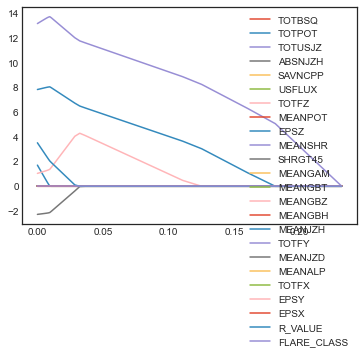

In [251]:
for i in range(n):
    plt.plot(alphas_lasso, coefs_lasso[i], label =subset_data.columns[i+1])
plt.legend();

In [282]:
X.shape, y.shape

((50, 24), (50,))

In [302]:
X.shape

(50, 24)

In [413]:
def lasso(X, y, l1, tol=1e-6, path_length=100, return_path=False):
    """The Lasso Regression model with intercept term.
    Intercept term included via design matrix augmentation.
    Pathwise coordinate descent with co-variance updates is applied.
    Path from max value of the L1 tuning parameter to input tuning parameter value.
    Features must be standardized (centered and scaled to unit variance)

    Params:
        X - NumPy matrix, size (N, p), of standardized numerical predictors
        y - NumPy array, length N, of numerical response
        l1 - L1 penalty tuning parameter (positive scalar)
        tol - Coordinate Descent convergence tolerance (exited if change < tol)
        path_length - Number of tuning parameter values to include in path (positive integer)
        return_path - Boolean indicating whether model coefficients along path should be returned

    Returns:
        if return_path == False:
            NumPy array, length p + 1, of fitted model coefficients
        if return_path == True:
            List, length 3, of last fitted model coefficients, tuning parameter path and coefficient values
    """
    X = np.hstack((np.ones((len(X), 1)), X))
    m, n = np.shape(X)
    B_star = np.zeros((n))
    l_max = max(list(abs(np.dot(np.transpose(X[:, 1:]), y)))) / m
    # At or above l_max, all coefficients (except intercept) will be brought to 0
    if l1 >= l_max:
        return np.append(np.mean(y), np.zeros((n - 1)))
    l_path = np.geomspace(l_max, l1, path_length)
    coeffiecients = np.zeros((len(l_path), n))
    for i in range(len(l_path)):
        while True:
            B_s = B_star
            for j in range(n):
                k = np.where(B_s != 0)[0]
                update = (1/m)*((np.dot(X[:,j], y)- \
                                np.dot(np.dot(X[:,j], X[:,k]), B_s[k]))) + \
                                B_s[j]
                B_star[j] = (np.sign(update) * max(abs(update) - l_path[i], 0))
            if np.all(abs(B_s - B_star) < tol):
                coeffiecients[i, :] = B_star
                break
    if return_path:
        return [B_star, l_path, coeffiecients]
    else:
        return B_star

In [443]:
lasso_cv = lasso(X, y, l1=0.001,path_length = 500,return_path=True)

In [482]:
lasso_cv[0][1:]

array([-1.90450993,  7.80315329, -0.        , -0.20740327,  2.90666376,
        0.14943014, -0.13440855,  0.16447738, -0.        ,  3.52050361,
       -1.35671701,  0.07797824, -0.0247798 ,  0.        , -0.1042161 ,
       -0.02312664, -0.        , -2.30193656,  0.        ,  0.        ,
        0.        , -0.23968797,  0.11907944,  0.30121209])

In [451]:
lasso_cv[1].shape

(500,)

In [449]:
lasso_cv[2][:,1:].shape

(500, 24)

In [456]:
subset_data.columns

Index(['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP',
       'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM',
       'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD',
       'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'FLARE_CLASS'],
      dtype='object')

In [462]:
legend_labels = list(subset_data.columns)[:-1]
legend_labels

['TOTUSJH',
 'TOTBSQ',
 'TOTPOT',
 'TOTUSJZ',
 'ABSNJZH',
 'SAVNCPP',
 'USFLUX',
 'TOTFZ',
 'MEANPOT',
 'EPSZ',
 'MEANSHR',
 'SHRGT45',
 'MEANGAM',
 'MEANGBT',
 'MEANGBZ',
 'MEANGBH',
 'MEANJZH',
 'TOTFY',
 'MEANJZD',
 'MEANALP',
 'TOTFX',
 'EPSY',
 'EPSX',
 'R_VALUE']

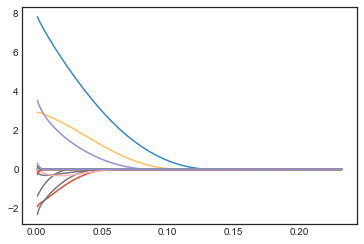

In [484]:

plt.plot(lasso_cv[1], lasso_cv[2][:,1:]);

In [367]:
lasso_cv[0][1:]

array([-1.90450993,  7.80315329, -0.        , -0.20740327,  2.90666376,
        0.14943014, -0.13440855,  0.16447738, -0.        ,  3.52050361,
       -1.35671701,  0.07797824, -0.0247798 ,  0.        , -0.1042161 ,
       -0.02312664, -0.        , -2.30193656,  0.        ,  0.        ,
        0.        , -0.23968797,  0.11907944,  0.30121209])

In [369]:
lasso_cv[1].shape

(500,)

In [426]:

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y,method='lasso',eps=0.001,n_alphas=500)

In [442]:
coefs_lasso.shape

(24, 500)

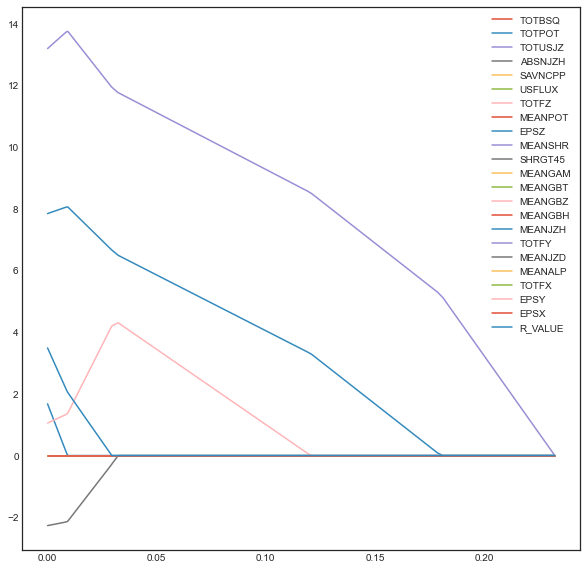

In [433]:
plt.figure(figsize = (10,10))
for i in range(n-1):
    plt.plot(alphas_lasso, coefs_lasso[i], label =subset_data.columns[i+1])
plt.legend();

In [439]:
coefs_lasso

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.67280086,
         1.67345188,  1.6740942 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  3.48667218,
         3.48722433,  3.48776896],
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ]])

In [435]:
alphas_lasso

array([2.32209377e-01, 2.29017005e-01, 2.25868520e-01, 2.22763320e-01,
       2.19700810e-01, 2.16680403e-01, 2.13701519e-01, 2.10763589e-01,
       2.07866049e-01, 2.05008344e-01, 2.02189926e-01, 1.99410255e-01,
       1.96668799e-01, 1.93965032e-01, 1.91298435e-01, 1.88668499e-01,
       1.86074718e-01, 1.83516596e-01, 1.80993643e-01, 1.78505375e-01,
       1.76051315e-01, 1.73630993e-01, 1.71243945e-01, 1.68889714e-01,
       1.66567849e-01, 1.64277904e-01, 1.62019441e-01, 1.59792027e-01,
       1.57595234e-01, 1.55428643e-01, 1.53291838e-01, 1.51184410e-01,
       1.49105954e-01, 1.47056072e-01, 1.45034371e-01, 1.43040465e-01,
       1.41073970e-01, 1.39134510e-01, 1.37221714e-01, 1.35335215e-01,
       1.33474650e-01, 1.31639665e-01, 1.29829906e-01, 1.28045028e-01,
       1.26284688e-01, 1.24548549e-01, 1.22836278e-01, 1.21147547e-01,
       1.19482032e-01, 1.17839414e-01, 1.16219379e-01, 1.14621616e-01,
       1.13045819e-01, 1.11491685e-01, 1.09958917e-01, 1.08447222e-01,
      

In [517]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.001)
lasso_coef = lasso.fit(X,y).coef_

In [518]:
lasso_coef

array([-0.56925876, 11.48185767,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  3.49220566,
       -0.35770298,  0.        , -0.        ,  0.        , -0.17163122,
        0.        ,  0.        , -3.45740102,  0.        ,  0.        ,
       -0.        , -1.29917349,  0.        ,  0.        ])

In [519]:
from sklearn import linear_model

In [522]:
_, _, coefs = linear_model.lars_path(X, y, method='lasso')

In [528]:
X.shape,y.shape

((50, 24), (50,))

In [529]:
xx

array([0.        , 0.17628234, 0.39960547, 0.76281631, 0.78023975,
       0.92564888, 1.        ])

In [494]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

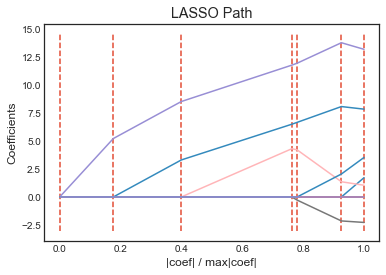

In [495]:
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [497]:
coefs.shape

(24, 7)

In [499]:
las = Lasso()
alphas = np.logspace(-5, 2, 1000)

In [500]:
alphas, coefs, _= las.path(X,y,alphas=alphas)

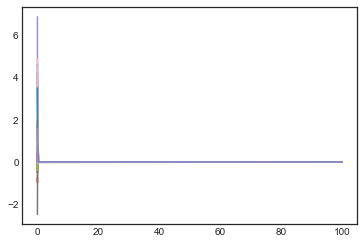

In [503]:
fig,ax = plt.subplots() 
ax.plot(alphas, coefs.T);

In [513]:
n_alphas = 10
alphas = np.logspace(-10, -2, n_alphas)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

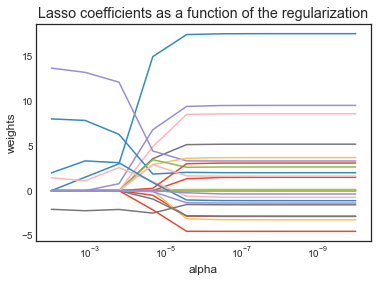

In [514]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [516]:
coefs

[array([-2.88091247e+00,  1.75590141e+01,  9.53847586e+00,  5.20144887e+00,
        -3.25722950e+00,  1.30826669e-01,  8.59981811e+00,  1.49750462e+00,
         2.00840855e+00,  3.32131543e+00, -2.85462918e+00,  3.70382686e+00,
         2.65364741e+00, -7.45583303e-01,  3.09493836e+00,  7.70265474e-04,
        -1.38682422e+00, -1.58236449e+00,  4.63668866e-02, -2.88785316e-02,
         1.62056461e+00, -4.54898510e+00, -1.11831592e+00, -3.76354056e-01]),
 array([-2.88090566e+00,  1.75589899e+01,  9.53844829e+00,  5.20143644e+00,
        -3.25720189e+00,  1.30825811e-01,  8.59980140e+00,  1.49746283e+00,
         2.00841852e+00,  3.32131739e+00, -2.85461646e+00,  3.70380799e+00,
         2.65363918e+00, -7.45552403e-01,  3.09491901e+00,  7.69742359e-04,
        -1.38681564e+00, -1.58235593e+00,  4.63659402e-02, -2.88781637e-02,
         1.62057210e+00, -4.54898347e+00, -1.11829722e+00, -3.76320018e-01]),
 array([-2.88085287e+00,  1.75588023e+01,  9.53823489e+00,  5.20134024e+00,
        

In [571]:
import numpy as np
from sklearn import datasets


class CoordinateDescentLasso:
    def __init__(self, alpha: float = 1.0, max_iter: int = 1000, fit_intercept: bool = True) -> None:
        self.alpha: float = alpha  # 正則化項の係数
        self.max_iter: int = max_iter  # 繰り返しの回数
        self.fit_intercept: bool = fit_intercept  # 切片(i.e., \beta_0)を用いるか
        self.coef_ = None  # 回帰係数(i.e., \beta)保存用変数
        self.intercept_ = None  # 切片保存用変数

    def _soft_thresholding_operator(self, x: float, lambda_: float) -> float:
        if x > 0.0 and lambda_ < abs(x):
            return x - lambda_
        elif x < 0.0 and lambda_ < abs(x):
            return x + lambda_
        else:
            return 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        if self.fit_intercept:
            X = np.column_stack((np.ones(len(X)), X))

        beta = np.zeros(X.shape[1])
        if self.fit_intercept:
            beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

        for iteration in range(self.max_iter):
            start = 1 if self.fit_intercept else 0
            for j in range(start, len(beta)):
                tmp_beta = beta.copy()
                tmp_beta[j] = 0.0
                r_j = y - np.dot(X, tmp_beta)
                arg1 = np.dot(X[:, j], r_j)
                arg2 = self.alpha * X.shape[0]

                beta[j] = self._soft_thresholding_operator(arg1, arg2) / (X[:, j]**2).sum()

                if self.fit_intercept:
                    beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

        if self.fit_intercept:
            self.intercept_ = beta[0]
            self.coef_ = beta[1:]
        else:
            self.coef_ = beta

        return self

    def predict(self, X: np.ndarray):
        y = np.dot(X, self.coef_)
        if self.fit_intercept:
            y += self.intercept_ * np.ones(len(y))
        return y


if __name__ == "__main__":
    
#     X = dataset.data
#     y = dataset.target

    X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)

    model = CoordinateDescentLasso(alpha=0.001)
    model.fit(X, y)

    print(model.intercept_)
    print(model.coef_)

1.9999999999999998
[ 0.0000000000e+00  1.0951435000e+00  0.0000000000e+00  0.0000000000e+00
  0.0000000000e+00  1.5162873846e-03  0.0000000000e+00  0.0000000000e+00
  0.0000000000e+00  3.0925850023e-01  0.0000000000e+00  0.0000000000e+00
  0.0000000000e+00  0.0000000000e+00 -8.5380441413e-04  0.0000000000e+00
  0.0000000000e+00 -3.2537417576e-01  0.0000000000e+00  0.0000000000e+00
 -1.0857286497e-02 -1.0053546594e-01  1.0140811690e-01  0.0000000000e+00]


In [640]:
np.log(0)

-inf

In [572]:
model.coef_

array([ 0.0000000000e+00,  1.0951435000e+00,  0.0000000000e+00,
        0.0000000000e+00,  0.0000000000e+00,  1.5162873846e-03,
        0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
        3.0925850023e-01,  0.0000000000e+00,  0.0000000000e+00,
        0.0000000000e+00,  0.0000000000e+00, -8.5380441413e-04,
        0.0000000000e+00,  0.0000000000e+00, -3.2537417576e-01,
        0.0000000000e+00,  0.0000000000e+00, -1.0857286497e-02,
       -1.0053546594e-01,  1.0140811690e-01,  0.0000000000e+00])

In [767]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [768]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [769]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.logspace(-3, -1, 30)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [770]:
search.fit(X,y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ...............model__alpha=0.001;, score=-0.619 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.001;, score=-0.557 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.001;, score=-1.079 total time=   0.0s
[CV 4/5] END ..............model__alpha=0.001;, score=-17.494 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.001;, score=-1.488 total time=   0.0s
[CV 1/5] END model__alpha=0.0011721022975334804;, score=-0.553 total time=   0.0s
[CV 2/5] END model__alpha=0.0011721022975334804;, score=-0.557 total time=   0.0s
[CV 3/5] END model__alpha=0.0011721022975334804;, score=-0.985 total time=   0.0s
[CV 4/5] END model__alpha=0.0011721022975334804;, score=-15.736 total time=   0.0s
[CV 5/5] END model__alpha=0.0011721022975334804;, score=-1.713 total time=   0.0s
[CV 1/5] END model__alpha=0.0013738237958832624;, score=-0.497 total time=   0.0s
[CV 2/5] END model__alpha=0.001373823795

[CV 1/5] END .model__alpha=0.03290344562312668;, score=-0.198 total time=   0.0s
[CV 2/5] END .model__alpha=0.03290344562312668;, score=-0.459 total time=   0.0s
[CV 3/5] END .model__alpha=0.03290344562312668;, score=-1.283 total time=   0.0s
[CV 4/5] END .model__alpha=0.03290344562312668;, score=-4.220 total time=   0.0s
[CV 5/5] END .model__alpha=0.03290344562312668;, score=-2.144 total time=   0.0s
[CV 1/5] END .model__alpha=0.03856620421163472;, score=-0.210 total time=   0.0s
[CV 2/5] END .model__alpha=0.03856620421163472;, score=-0.443 total time=   0.0s
[CV 3/5] END .model__alpha=0.03856620421163472;, score=-1.280 total time=   0.0s
[CV 4/5] END .model__alpha=0.03856620421163472;, score=-4.184 total time=   0.0s
[CV 5/5] END .model__alpha=0.03856620421163472;, score=-2.131 total time=   0.0s
[CV 1/5] END .model__alpha=0.04520353656360243;, score=-0.225 total time=   0.0s
[CV 2/5] END .model__alpha=0.04520353656360243;, score=-0.423 total time=   0.0s
[CV 3/5] END .model__alpha=0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.001       , 0.0011721023, 0.0013738238, 0.001610262 ,
       0.0018873918, 0.0022122163, 0.0025929438, 0.0030391954,
       0.0035622479, 0.0041753189, 0.0048939009, 0.0057361525,
       0.0067233575, 0.0078804628, 0.0092367086, 0.0108263673,
       0.01268961  , 0.0148735211, 0.0174332882, 0.0204335972,
       0.0239502662, 0.028072162 , 0.0329034456, 0.0385662042,
       0.0452035366, 0.0529831691, 0.0621016942, 0.0727895384,
       0.0853167852, 0.1         ])},
             scoring='neg_mean_squared_error', verbose=3)

In [771]:
search.best_params_

{'model__alpha': 0.010826367338740546}

In [772]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [773]:
coefficients.shape

(24,)

In [774]:
importance = np.abs(coefficients)

In [775]:
importance

array([0.          , 0.6038446561, 0.          , 0.          ,
       0.          , 0.          , 0.          , 0.          ,
       0.          , 0.6793298264, 0.          , 0.          ,
       0.          , 0.          , 0.0068976561, 0.          ,
       0.          , 0.266336327 , 0.          , 0.          ,
       0.2130311428, 0.          , 0.0992416756, 0.          ])

In [776]:
subset_data.columns[:-1].shape

(24,)

In [777]:
np.array(subset_data.columns[:-1])[importance > 0]

array(['TOTBSQ', 'EPSZ', 'MEANGBZ', 'TOTFY', 'TOTFX', 'EPSX'],
      dtype=object)

In [778]:
np.array(subset_data.columns[:-1])[importance == 0]

array(['TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
       'TOTFZ', 'MEANPOT', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT',
       'MEANGBH', 'MEANJZH', 'MEANJZD', 'MEANALP', 'EPSY', 'R_VALUE'],
      dtype=object)

In [779]:
import numpy as np
from sklearn import datasets


class CoordinateDescentLasso:
    def __init__(self, alpha: float = 1.0, max_iter: int = 1000, fit_intercept: bool = True) -> None:
        self.alpha: float = alpha  # 正則化項の係数
        self.max_iter: int = max_iter  # 繰り返しの回数
        self.fit_intercept: bool = fit_intercept  # 切片(i.e., \beta_0)を用いるか
        self.coef_ = None  # 回帰係数(i.e., \beta)保存用変数
        self.intercept_ = None  # 切片保存用変数

    def _soft_thresholding_operator(self, x: float, lambda_: float) -> float:
        if x > 0.0 and lambda_ < abs(x):
            return x - lambda_
        elif x < 0.0 and lambda_ < abs(x):
            return x + lambda_
        else:
            return 0.0

    def fit(self, X: np.ndarray, y: np.ndarray):
        if self.fit_intercept:
            X = np.column_stack((np.ones(len(X)), X))

        beta = np.zeros(X.shape[1])
        if self.fit_intercept:
            beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

        for iteration in range(self.max_iter):
            start = 1 if self.fit_intercept else 0
            for j in range(start, len(beta)):
                tmp_beta = beta.copy()
                tmp_beta[j] = 0.0
                r_j = y - np.dot(X, tmp_beta)
                arg1 = np.dot(X[:, j], r_j)
                arg2 = self.alpha * X.shape[0]

                beta[j] = self._soft_thresholding_operator(arg1, arg2) / (X[:, j]**2).sum()

                if self.fit_intercept:
                    beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

        if self.fit_intercept:
            self.intercept_ = beta[0]
            self.coef_ = beta[1:]
        else:
            self.coef_ = beta

        return self

    def predict(self, X: np.ndarray):
        y = np.dot(X, self.coef_)
        if self.fit_intercept:
            y += self.intercept_ * np.ones(len(y))
        return y



X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)

model = CoordinateDescentLasso(alpha=0.01)
model.fit(X, y)
intercept = model.intercept_
coefs = model.coef_
print(model.intercept_)
print(model.coef_)

2.0
[ 0.            0.5971788216  0.            0.            0.
  0.            0.            0.            0.            0.6858510324
  0.            0.            0.            0.           -0.0063190413
  0.            0.           -0.2658090924  0.            0.
 -0.2166168874  0.            0.1005406907  0.          ]


In [780]:
importance = np.abs(coefs)
np.array(subset_data.columns[:-1])[importance > 0]

array(['TOTBSQ', 'EPSZ', 'MEANGBZ', 'TOTFY', 'TOTFX', 'EPSX'],
      dtype=object)

In [781]:
np.array(subset_data.columns[:-1])[importance == 0]

array(['TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
       'TOTFZ', 'MEANPOT', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT',
       'MEANGBH', 'MEANJZH', 'MEANJZD', 'MEANALP', 'EPSY', 'R_VALUE'],
      dtype=object)

In [782]:
coefficients

array([-0.          ,  0.6038446561,  0.          ,  0.          ,
        0.          ,  0.          , -0.          ,  0.          ,
        0.          ,  0.6793298264, -0.          , -0.          ,
       -0.          ,  0.          , -0.0068976561, -0.          ,
       -0.          , -0.266336327 ,  0.          ,  0.          ,
       -0.2130311428, -0.          ,  0.0992416756,  0.          ])

In [783]:
coefs

array([ 0.          ,  0.5971788216,  0.          ,  0.          ,
        0.          ,  0.          ,  0.          ,  0.          ,
        0.          ,  0.6858510324,  0.          ,  0.          ,
        0.          ,  0.          , -0.0063190413,  0.          ,
        0.          , -0.2658090924,  0.          ,  0.          ,
       -0.2166168874,  0.          ,  0.1005406907,  0.          ])

In [784]:
error = np.mean( coefficients!= coefs) 

In [785]:
error

0.25

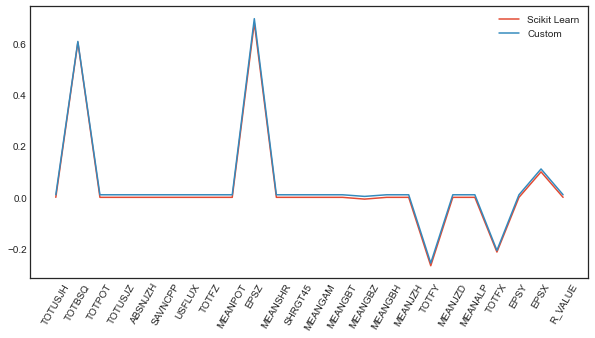

In [789]:
plt.figure(figsize = (10,5))
x = subset_data.columns[:-1]
plt.plot(x,coefficients, label="Scikit Learn")
plt.plot(x,coefs+0.01, label="Custom")
plt.legend();
plt.xticks(rotation = 60);

In [754]:
range(25)

range(0, 25)

(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)


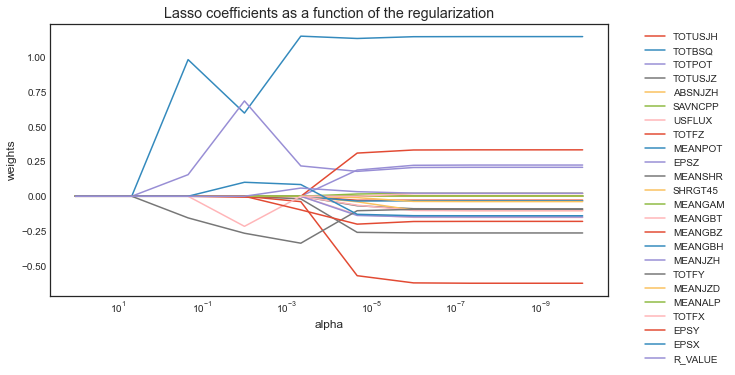

In [755]:
n_alphas = 10
alphas = np.logspace(-10, 2, n_alphas)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)
    print(lasso.coef_.shape)
    coefs.append(lasso.coef_)
    
NUM_COLORS = 24
cm = plt.get_cmap('gist_rainbow')
plt.figure(figsize= (10,5))   
ax = plt.gca()


ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(subset_data.columns[:-1], bbox_to_anchor = (1.05,1))
plt.show()

No handles with labels found to put in legend.


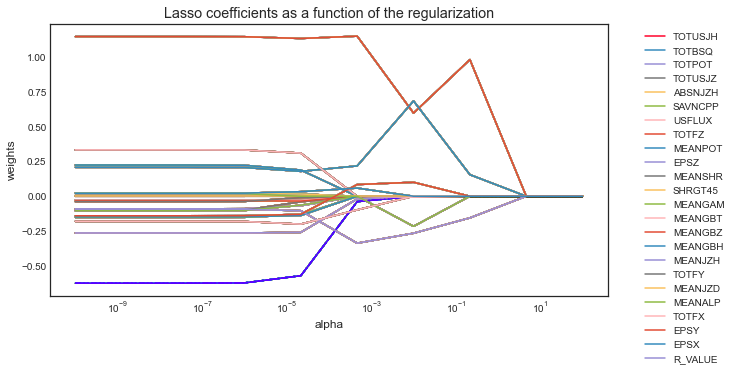

In [756]:
n_alphas = 10
alphas = np.logspace(-10, 2, n_alphas)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
NUM_COLORS = 24
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)
cm = plt.get_cmap('gist_rainbow')
plt.figure(figsize= (10,5))   
ax = plt.gca()
for i in range(NUM_COLORS):
    lines = ax.plot(alphas, coefs)
    lines[0].set_color(cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])


ax.legend()
ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(subset_data.columns[:-1], bbox_to_anchor = (1.05,1))
plt.show()

In [757]:
np.array(coefs)[9]

array([-0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0., -0.,
        0., -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.])

In [758]:
alphas

array([1.0000000000e-10, 2.1544346900e-09, 4.6415888336e-08,
       1.0000000000e-06, 2.1544346900e-05, 4.6415888336e-04,
       1.0000000000e-02, 2.1544346900e-01, 4.6415888336e+00,
       1.0000000000e+02])

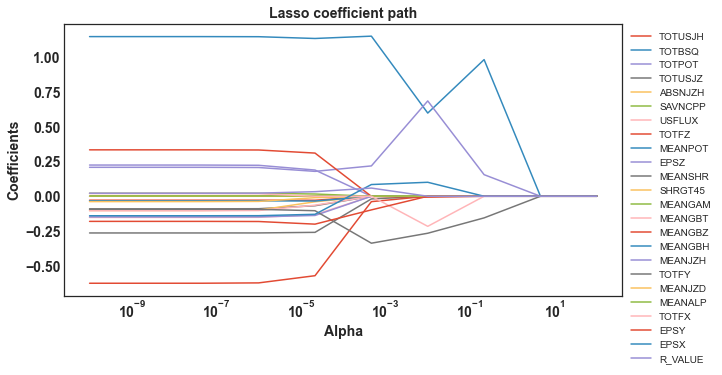

In [759]:
n_alphas = 10
alphas = np.logspace(-10, 2, n_alphas)
coefs_scikit_learn = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)

    coefs_scikit_learn.append(lasso.coef_)

plt.figure(figsize= (10,5))   
ax = plt.gca()


ax.plot(alphas, coefs_scikit_learn)
ax.set_xscale('log')


plt.xlabel('Alpha', fontweight='bold',fontsize=14)
plt.xticks(fontweight='bold', fontsize=14)
plt.ylabel('Coefficients',fontweight='bold',fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)
plt.title('Lasso coefficient path',fontweight='bold',fontsize=14)
plt.axis('tight')
plt.legend(subset_data.columns[:-1], bbox_to_anchor = (1,1))
plt.show()

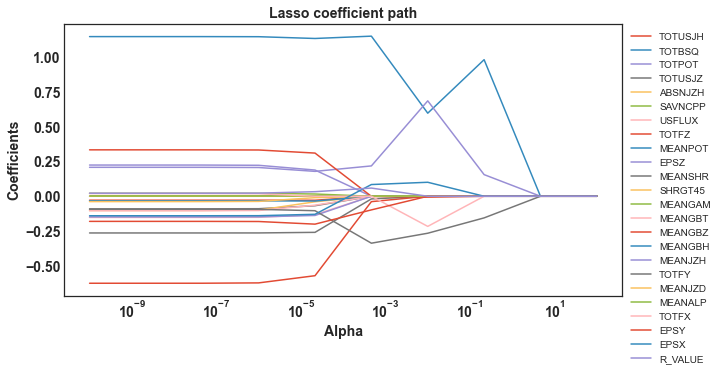

In [760]:
n_alphas = 10
alphas = np.logspace(-10, 2, n_alphas)
coefs_custom = []
for a in alphas:
    lasso = CoordinateDescentLasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)
    coefss = lasso.coef_
    coefs_custom.append(coefss)

plt.figure(figsize= (10,5))   
ax = plt.gca()


ax.plot(alphas, coefs_custom)
ax.set_xscale('log')


plt.xlabel('Alpha', fontweight='bold',fontsize=14)
plt.xticks(fontweight='bold', fontsize=14)
plt.ylabel('Coefficients',fontweight='bold',fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)
plt.title('Lasso coefficient path',fontweight='bold',fontsize=14)
plt.axis('tight')
plt.legend(subset_data.columns[:-1], bbox_to_anchor = (1,1))
plt.show()

In [761]:
coefs_custom[1]

array([-6.2533060005e-01,  1.1476598743e+00,  2.2437029735e-01,
       -9.0486357540e-02, -1.0196883151e-01,  0.0000000000e+00,
       -1.5230583143e-01, -2.8403409941e-02, -3.2685946080e-02,
        2.0799318832e-01, -2.6386728475e-01, -3.8479269129e-02,
        2.1529655332e-02, -1.0434035124e-01,  3.3365657945e-01,
       -6.4998248612e-09, -1.4856226940e-01, -9.3574496030e-02,
        9.1339696768e-09,  0.0000000000e+00,  1.9501049953e-02,
       -1.8058231896e-01, -1.4018466578e-01,  2.1843985662e-02])

In [762]:
coefs_scikit_learn[1]

array([-6.2533060005e-01,  1.1476598743e+00,  2.2437029735e-01,
       -9.0486357540e-02, -1.0196883151e-01,  0.0000000000e+00,
       -1.5230583143e-01, -2.8403409941e-02, -3.2685946080e-02,
        2.0799318832e-01, -2.6386728475e-01, -3.8479269129e-02,
        2.1529655332e-02, -1.0434035124e-01,  3.3365657945e-01,
       -6.4998218569e-09, -1.4856226940e-01, -9.3574496030e-02,
        9.1339629755e-09, -0.0000000000e+00,  1.9501049953e-02,
       -1.8058231896e-01, -1.4018466578e-01,  2.1843985662e-02])

In [763]:
error = np.mean( coefs_custom[0]!= coefs_scikit_learn[0]) 

In [764]:
for i in range(len(coefs_custom[1])):
    if coefs_custom[1][i] != coefs_scikit_learn[1][i]:
        print("Yes")

Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes


In [765]:
coefs_custom[1][0], coefs_scikit_learn[1][0]

(-0.6253306000497948, -0.6253306000497916)